🎮 Executando em: cpu
📥 Carregando MiDaS Deep Learning (DPT Large)...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



📸 Selecione a imagem ESQUERDA (será a base do mapa):


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Saving left.jpg to left (3).jpg
🧠 Estimando profundidade com Vision Transformers...


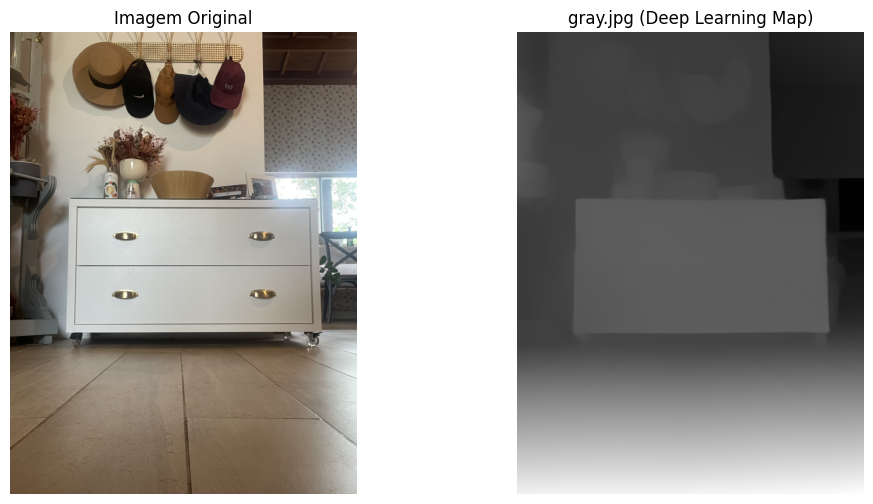


✅ Sucesso! Baixando arquivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import torch
import cv2
import numpy as np
import json
from google.colab import files
import matplotlib.pyplot as plt

# ========================================================================
# 1. CARREGAMENTO DO MODELO (Via Torch Hub - 100% Estável)
# ========================================================================
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🎮 Executando em: {device}")

print("📥 Carregando MiDaS Deep Learning (DPT Large)...")
# O modelo DPT Large é excelente para Point Clouds por causa da alta resolução
model = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
model.to(device).eval()

# Carregar transformações oficiais
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# ========================================================================
# 2. UPLOAD DAS IMAGENS
# ========================================================================
print("\n📸 Selecione a imagem ESQUERDA (será a base do mapa):")
uploaded = files.upload()
img_name = list(uploaded.keys())[0]

img = cv2.imread(img_name)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# ========================================================================
# 3. INFERÊNCIA DE PROFUNDIDADE
# ========================================================================
print("🧠 Estimando profundidade com Vision Transformers...")
input_batch = transform(img_rgb).to(device)

with torch.no_grad():
    prediction = model(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

# ========================================================================
# 4. GERAÇÃO DO gray.jpg E map.json
# ========================================================================
# Normalização para 0-255 (Escala de Cinza)
# No MiDaS, valores maiores = mais perto (igual disparidade)
out_min, out_max = output.min(), output.max()
gray_map = (255 * (output - out_min) / (out_max - out_min)).astype(np.uint8)

# Salvar Imagem
cv2.imwrite('gray.jpg', gray_map)

# Gerar Metadados
# Como o MiDaS é relativo, estimamos a disparidade máxima para o seu baseline
# Um valor comum para disparidade máxima em fotos estéreo é ~10% da largura
max_disp_estimada = w * 0.1

map_data = {
    "method": "MiDaS DPT Large (Deep Learning)",
    "imageSize": {"width": w, "height": h},
    "maxDisparity": float(max_disp_estimada),
    "numDisparities": int(np.ceil(max_disp_estimada/16)*16),
    "baseline_mm": 330.0,
    "scale_factor_gray": float(max_disp_estimada / 255.0),
    "notes": "Profundidade calculada via Vision Transformer (DPT)"
}

with open('map.json', 'w') as f:
    json.dump(map_data, f, indent=4)

# ========================================================================
# 5. VISUALIZAÇÃO E DOWNLOAD
# ========================================================================
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_map, cmap='gray')
plt.title("gray.jpg (Deep Learning Map)")
plt.axis('off')
plt.show()

print("\n✅ Sucesso! Baixando arquivos...")
files.download('gray.jpg')
files.download('map.json')